# How to use fractional gates  
Usage of the $R_X(\theta)$ gate can reduce the duration execution of the $R_ZZ(\theta)$ qubit rotations of arbitrary angle by up to a factor of two. The direct execution of the $R_ZZ(\theta)$ gate rotation avoids decomposition into multiple ```CZGate```s, simiarly reducing a circuit's duration and error. This is especially useful for circuitts that contain many single- and two-qubit rotations, such as when simulating the dynamics of a quantum system or when using avariational ansatz with many parameters  

But, these gates can only be used on specific IBM QPUs which must be loaded with the flag ```use_fractional_gates``` set to ```True```. This flag will ensure that fractional gates are included in the backend's ```Target``` for the transpiler

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(use_fractional_gates=True)
print(f"Using backend: {backend.name}")

Using backend: ibm_fez


The error value repported in the ```Target``` of a backend with fractional gates enabled is just a copy of the non-fractional gate's counterpart. This is because the reporting of error rates on the fractional gates is not yet supported  

However, since the gate time of fractional versus non-fractional gates are the same, it is a resonable assumption that their error rates are comparable, 

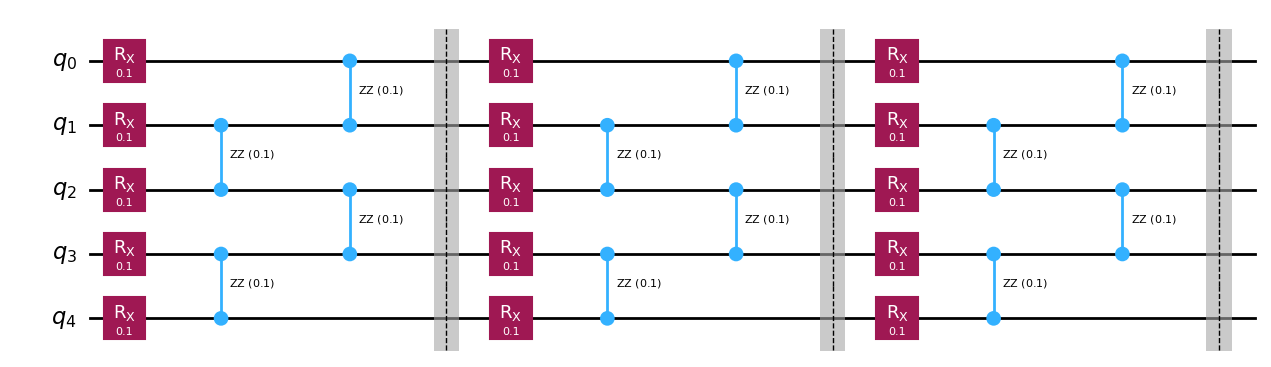

In [11]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.visualization.timeline import draw as draw_timeline, IQXSimple

num_qubits = 5
num_time_steps = 3
rx_angle = 0.1
rzz_angle = 0.1

ising_circuit = QuantumCircuit(num_qubits)
for i in range(num_time_steps):
    # rx layer
    for q in range(num_qubits):
        ising_circuit.rx(rx_angle, q)
    for q in range(1, num_qubits - 1, 2):
        ising_circuit.rzz(rzz_angle, q, q + 1)
    # 2nd rzz layer
    for q in range(0, num_qubits - 1, 2):
        ising_circuit.rzz(rzz_angle, q, q + 1)
    ising_circuit.barrier()
ising_circuit.draw("mpl")

In [30]:
service = QiskitRuntimeService()
backend_fractional = service.backend("ibm_torino", use_fractional_gates=True)
backend_conventional = service.backend(
    "ibm_torino", use_fractional_gates=False
)
 
pm_fractional = generate_preset_pass_manager(
    optimization_level=3, backend=backend_fractional, scheduling_method="alap"
)
pm_conventional = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend_conventional,
    scheduling_method="alap",
)
 
ising_circuit_fractional = pm_fractional.run(ising_circuit)
ising_circuit_conventional = pm_conventional.run(ising_circuit)

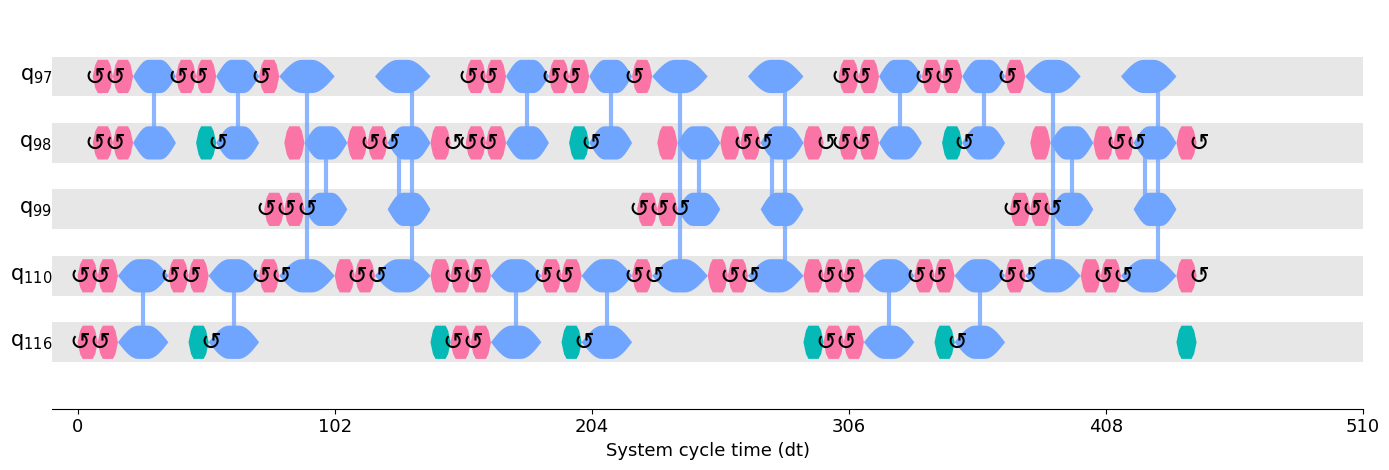

In [31]:
# Draw timeline of circuit with conventional gates
draw_timeline(
    ising_circuit_conventional,
    idle_wires=False,
    target=backend_conventional.target,
    time_range=(0, 500),
    style=IQXSimple(),
)

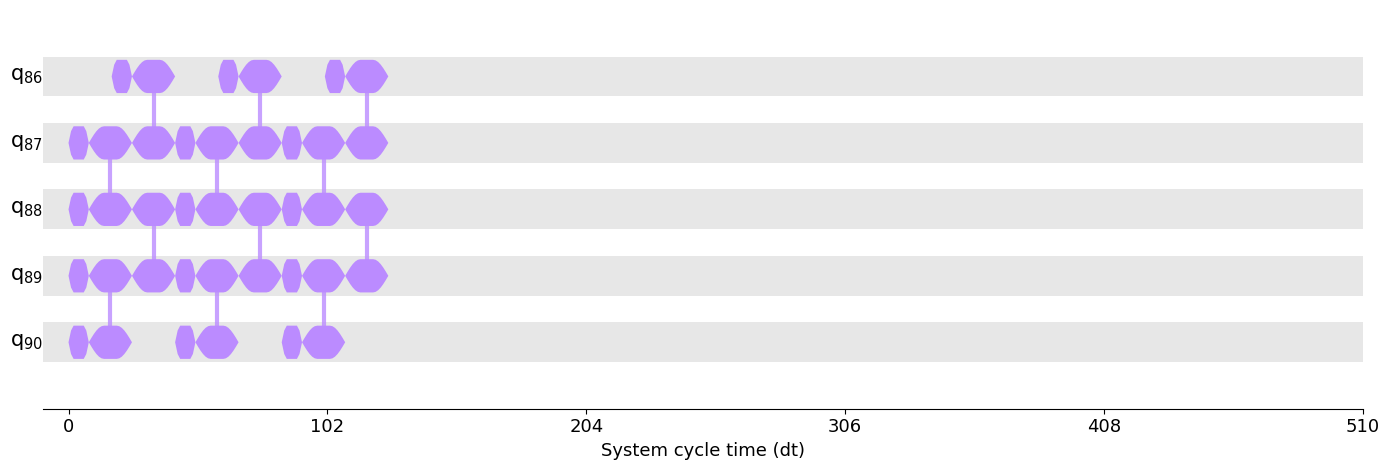

In [32]:
# Draw timeline of circuit with fractional gates
draw_timeline(
    ising_circuit_fractional,
    idle_wires=False,
    target=backend_fractional.target,
    time_range=(0, 500),
    style=IQXSimple(),
)

# Where to use fractional gates  
Historically, the basis gates available on IBM QPUs have been ```CZ, X, RZ, SX, ID```, which can't efficiently represent circuits with single- and two- qubit rotations that are not multiple of $\pi/2$   
Similarly, when two-qubit rotations such as an $R_ZZ(\theta)$ gate are transpiled, the decompision requires two ```CZ``` gates and several single-qubit gates, which increases the circuit depth

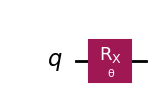

In [36]:
qc = QuantumCircuit(1)
param = Parameter("θ")
qc.rx(param, 0)
qc.draw("mpl")

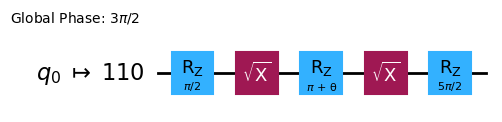

In [ ]:
# Decomposition of an RX(θ) gate using the IBM Quantum QPU basis
service = QiskitRuntimeService()
backend = service.backend("ibm_torino")
optimization_level = 3
pm = generate_preset_pass_manager(optimization_level, backend=backend)
transpiled_circuit = pm.run(qc)
transpiled_circuit.draw("mpl", idle_wires=False)

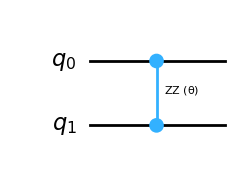

In [44]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.transpiler import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
 
qc = QuantumCircuit(2)
param = Parameter("θ")
qc.rzz(param, 0, 1)
qc.draw("mpl")

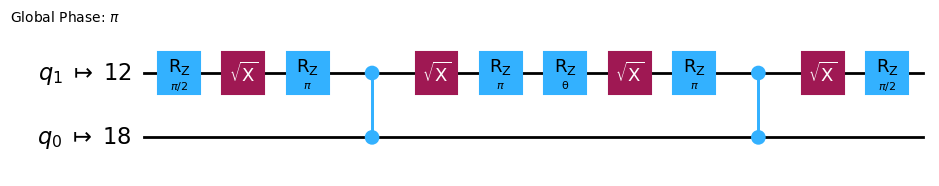

In [45]:
# Decomposition of an RZZ(θ) gate using the IBM Quantum QPU basis
service = QiskitRuntimeService()
backend = service.backend("ibm_torino")
optimization_level = 3
pm = generate_preset_pass_manager(optimization_level, backend=backend)
transpiled_circuit = pm.run(qc)
transpiled_circuit.draw("mpl", idle_wires=False)

For workflows that require many single-qubit $R_X(\theta)$  or two-qubit rotations (such as in a variational ansatz or when simulating the time evolution of quantum systems), this constraint causes the circuit depth to grow rapidly. However, fractional gates remove this requirement, because the single- and two-qubit rotations are executed directly, and create a more efficient (and thus error-suppressed) quantum circuit.

# (번외) PINN-Laplace Equation for experimental demo

Using device: cuda

--- 학습 1: Standard NN (Loss = L_data) ---
NN Epoch 0, Loss: 1.0687e-01
NN Epoch 1000, Loss: 7.7312e-04
NN Epoch 2000, Loss: 3.5507e-05
NN Epoch 3000, Loss: 1.0876e-05
NN Epoch 4000, Loss: 5.4878e-06
NN Epoch 5000, Loss: 7.9693e-05

--- 학습 2: PINN (Loss = L_data + L_phys) ---
PINN Epoch 0, Loss: 1.3760e-01 (Data: 1.3710e-01, Phys: 4.9788e-04)
PINN Epoch 1000, Loss: 2.5389e-03 (Data: 1.9160e-03, Phys: 6.2285e-04)
PINN Epoch 2000, Loss: 6.5941e-04 (Data: 4.0364e-04, Phys: 2.5577e-04)
PINN Epoch 3000, Loss: 5.7630e-04 (Data: 2.3679e-04, Phys: 3.3950e-04)
PINN Epoch 4000, Loss: 1.6500e-04 (Data: 1.0858e-04, Phys: 5.6422e-05)
PINN Epoch 5000, Loss: 1.2459e-04 (Data: 7.8160e-05, Phys: 4.6434e-05)


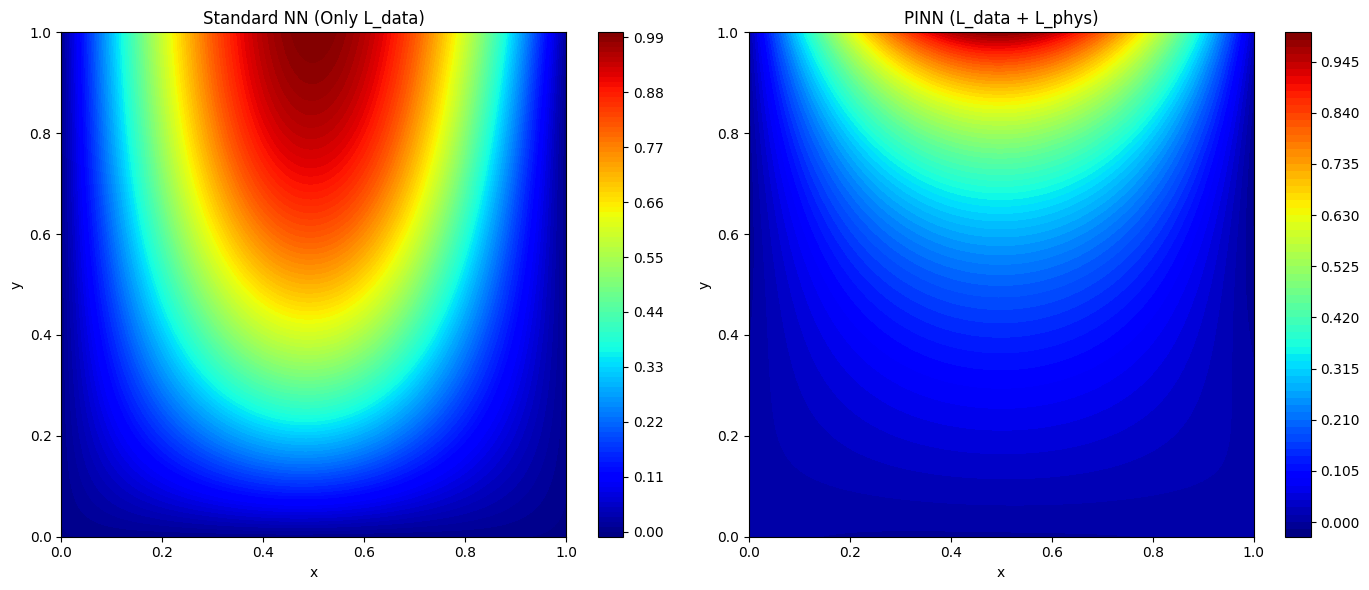

In [46]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- 1. 모델 정의 (Standard MLP) ---
# (x, y) 2개 입력을 받아 u 1개 출력
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )
    
    def forward(self, x, y):
        # 입력 (x, y)를 결합
        inputs = torch.cat([x, y], dim=1)
        return self.net(inputs)

# --- 2. 학습 준비 ---
mse_loss = nn.MSELoss()

def create_training_data(n_bc=100, n_phys=1000):
    # 1. 경계 조건 (Boundary Conditions) 데이터 (L_data 용)
    
    # 위쪽: u(x, 1) = sin(pi*x)
    x_top = torch.rand(n_bc, 1)
    y_top = torch.ones_like(x_top)
    u_top = torch.sin(torch.pi * x_top)
    
    # 아래쪽: u(x, 0) = 0
    x_bottom = torch.rand(n_bc, 1)
    y_bottom = torch.zeros_like(x_bottom)
    u_bottom = torch.zeros_like(x_bottom)
    
    # 왼쪽: u(0, y) = 0
    x_left = torch.zeros(n_bc, 1)
    y_left = torch.rand(n_bc, 1)
    u_left = torch.zeros_like(x_left)
    
    # 오른쪽: u(1, y) = 0
    x_right = torch.ones(n_bc, 1)
    y_right = torch.rand(n_bc, 1)
    u_right = torch.zeros_like(x_right)
    
    # 모든 경계 데이터 결합
    bc_x = torch.cat([x_top, x_bottom, x_left, x_right]).to(device)
    bc_y = torch.cat([y_top, y_bottom, y_left, y_right]).to(device)
    bc_u = torch.cat([u_top, u_bottom, u_left, u_right]).to(device)
    
    # 2. 물리 손실 (Physics Loss) 데이터 (L_phys 용)
    # 도메인 내부의 임의의 점들
    phys_x = torch.rand(n_phys, 1).to(device)
    phys_y = torch.rand(n_phys, 1).to(device)
    
    # ★★★ 자동 미분(AD)을 위해 grad=True 설정 ★★★
    phys_x.requires_grad = True
    phys_y.requires_grad = True
    
    return bc_x, bc_y, bc_u, phys_x, phys_y

# 2차 미분을 계산하는 함수 (AD 사용)
def compute_laplacian(model, x, y):
    u = model(x, y)
    
    # 1차 미분: u_x = du/dx, u_y = du/dy
    grad_u = torch.autograd.grad(
        u, [x, y], 
        grad_outputs=torch.ones_like(u), 
        create_graph=True
    )
    u_x = grad_u[0]
    u_y = grad_u[1]
    
    # 2차 미분: u_xx = d(u_x)/dx, u_yy = d(u_y)/dy
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    
    laplacian = u_xx + u_yy
    return laplacian

# 시각화 함수
def plot_solution(model, ax, title):
    model.to("cpu")
    x = torch.linspace(0, 1, 100)
    y = torch.linspace(0, 1, 100)
    X, Y = torch.meshgrid(x, y, indexing="ij")
    X_flat = X.flatten().unsqueeze(1)
    Y_flat = Y.flatten().unsqueeze(1)
    
    with torch.no_grad():
        U_flat = model(X_flat, Y_flat)
    
    U = U_flat.reshape(100, 100).cpu().numpy()
    
    c = ax.contourf(X.numpy(), Y.numpy(), U, levels=100, cmap="jet")
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.colorbar(c, ax=ax)
    model.to(device)

# --- 3. 학습 1: 물리 손실이 *없는* 경우 (Standard NN) ---
print("\n--- 학습 1: Standard NN (Loss = L_data) ---")
model_nn = PINN().to(device)
optimizer_nn = torch.optim.Adam(model_nn.parameters(), lr=1e-3)
bc_x, bc_y, bc_u, phys_x, phys_y = create_training_data()

for epoch in range(5001):
    optimizer_nn.zero_grad()
    
    # 경계에서의 예측
    u_pred_bc = model_nn(bc_x, bc_y)
    
    # 오직 데이터 손실(경계 손실)만 사용
    loss_data = mse_loss(u_pred_bc, bc_u)
    loss = loss_data
    
    loss.backward()
    optimizer_nn.step()
    
    if epoch % 1000 == 0:
        print(f"NN Epoch {epoch}, Loss: {loss.item():.4e}")

# --- 4. 학습 2: 물리 손실이 *있는* 경우 (PINN) ---
print("\n--- 학습 2: PINN (Loss = L_data + L_phys) ---")
model_pinn = PINN().to(device)
optimizer_pinn = torch.optim.Adam(model_pinn.parameters(), lr=1e-3)
# (데이터는 동일하게 사용)

for epoch in range(5001):
    optimizer_pinn.zero_grad()
    
    # 1. 데이터 손실 (L_data)
    u_pred_bc = model_pinn(bc_x, bc_y)
    loss_data = mse_loss(u_pred_bc, bc_u)
    
    # 2. 물리 손실 (L_phys)
    laplacian_pred = compute_laplacian(model_pinn, phys_x, phys_y)
    target_zero = torch.zeros_like(laplacian_pred)
    loss_phys = mse_loss(laplacian_pred, target_zero)
    
    # 손실 결합
    loss = loss_data + 1.0 * loss_phys # lambda = 1.0
    
    loss.backward()
    optimizer_pinn.step()
    
    if epoch % 1000 == 0:
        print(f"PINN Epoch {epoch}, Loss: {loss.item():.4e} (Data: {loss_data.item():.4e}, Phys: {loss_phys.item():.4e})")

# --- 5. 결과 비교 시각화 ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_solution(model_nn, axes[0], "Standard NN (Only L_data)")
plot_solution(model_pinn, axes[1], "PINN (L_data + L_phys)")

plt.tight_layout()
plt.show()